In [1]:
!pip install -U datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 24.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.5
    Uninstalling huggingface-hub-0.33.5:
      Successfully uninstalled huggingface-hub-0.33.5
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

This code verifies if a GPU is available and prints its name if found. This is important for accelerating the training process.

In [3]:
!nvidia-smi

Tue Jul 29 00:55:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import torch

# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# Print GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

GPU Available: True
GPU Name: Tesla T4


# **Data Loading and Preprocessing**
This section loads the consumer complaints data from a CSV file,
preprocesses it by renaming columns, and creates a label mapping for the target variable.

In [5]:
# 1. Load and Preprocess the Data
# --------------------------------
# Assume you have downloaded the CSV locally (e.g., 'consumer_complaints.csv').
# Here, we load the CSV, rename columns to standardize (e.g. lower-case with underscores),
# and then create a label mapping for the target variable ("product").

complaints_df = pd.read_csv("/content/complaints-2025.csv")

In [6]:
complaints_df.shape

(18225, 3)

In [7]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18225 entries, 0 to 18224
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Issue                         18225 non-null  object
 1   Sub-issue                     18225 non-null  object
 2   Consumer complaint narrative  7931 non-null   object
dtypes: object(3)
memory usage: 427.3+ KB


In [8]:
complaints_df.head(10)

,Issue,Sub-issue,Consumer complaint narrative
0,Getting a credit card,Application denied,I completed one of the many offers that Wells ...
1,Fees or interest,Problem with fees,NaN
2,Closing your account,Can't close your account,NaN
3,"Advertising and marketing, including promotion...",Didn't receive advertised or promotional terms,"I applied for a credit card at Capital One, ca..."
4,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,"On XX/XX/year>, I purchased a product describe..."
5,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,NaN
6,"Advertising and marketing, including promotion...",Confusing or misleading advertising about the ...,Today XX/XX/year> at XXXX XXXX I wanted to up...
7,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,"On XX/XX/XXXX, I pre purchased a rental from X..."
8,Getting a credit card,Card opened without my consent or knowledge,NaN
9,Getting a credit card,Card opened without my consent or knowledge,NaN


In [9]:
issues_df = complaints_df.Issue.value_counts().reset_index()

In [10]:
issues_df.head(10)

,Issue,count
0,Problem with a purchase shown on your statement,6780
1,Getting a credit card,4878
2,Fees or interest,3269
3,Closing your account,2124
4,"Advertising and marketing, including promotion...",1174


In [11]:
num_labels = len(issues_df.Issue.unique())

In [12]:
num_labels

5


Here, we select the relevant columns for text classification (narrative and issue) and rename them for clarity.


In [13]:
complaints_df = complaints_df[["Consumer complaint narrative", "Issue"]].dropna().reset_index()

In [14]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7931 entries, 0 to 7930
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   index                         7931 non-null   int64 
 1   Consumer complaint narrative  7931 non-null   object
 2   Issue                         7931 non-null   object
dtypes: int64(1), object(2)
memory usage: 186.0+ KB


In [15]:
df = complaints_df[['Consumer complaint narrative', 'Issue']]
df.columns = ['Narrative', 'labels']

This section converts the pandas DataFrame to a Hugging Face Dataset and encodes the labels for classification.

In [16]:
# Convert the pandas DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

dataset = dataset.class_encode_column("labels")

Casting to class labels:   0%|          | 0/7931 [00:00<?, ? examples/s]

In [17]:
# Get label mapping as a dictionary
label_mapping = {idx: label for idx, label in enumerate(dataset.features["labels"].names)}

# Print dictionary
label_mapping


{0: 'Advertising and marketing, including promotional offers',
 1: 'Closing your account',
 2: 'Fees or interest',
 3: 'Getting a credit card',
 4: 'Problem with a purchase shown on your statement'}

In [18]:
# Split into train and test sets (80-20 split)
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

## Load the tokenizer and prepare encode the datasets

This section defines a function to tokenize the text data using the chosen model's tokenizer. It then applies the tokenization to both training and evaluation datasets.

In [19]:
# 2. Tokenize the Data
# ---------------------
# Load the tokenizer from the chosen model and define a function to tokenize each example.
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    # Tokenize the complaint narrative text.
    return tokenizer(
        example["Narrative"],
        truncation=True,
        padding=True,
        max_length=128  # adjust max_length based on your data and available compute
    )

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [20]:
# Apply the tokenization to both train and evaluation datasets.
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6344 [00:00<?, ? examples/s]

Map:   0%|          | 0/1587 [00:00<?, ? examples/s]

In [21]:
print(train_dataset.column_names)  # Should include 'input_ids', 'attention_mask', and 'labels'

['Narrative', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']


In [22]:
# Remove unnecessary columns (keeping only the input IDs, attention masks, and label)
columns_to_remove = [col for col in train_dataset.column_names if col not in ["input_ids", "attention_mask", "labels"]]
train_dataset = train_dataset.remove_columns(columns_to_remove)
eval_dataset = eval_dataset.remove_columns(columns_to_remove)

# Set the format for PyTorch (so that the Trainer can work with torch tensors)
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

This function generator creates a compute_metrics function based on the provided configuration.

You can set which metrics to compute by modifying the metric_config dictionary.


In [25]:
train_dataset

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 6344
})

## Load the pre-trained FinBERT model

In [24]:
# 4. Load and Configure the Model
# --------------------------------
# For a classification task, we load a pre-trained model for sequence classification and specify the number of labels.
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, ignore_mismatched_sizes=True)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Evaluating the model with evaluation dataset

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Run predictions
true_labels = []
pred_labels = []

batch_size = 32
for i in range(0, len(eval_dataset), batch_size):
    batch = eval_dataset[i:i+batch_size]

    input_ids = torch.tensor(batch['input_ids']).to(device)
    attention_mask = torch.tensor(batch['attention_mask']).to(device)
    labels = batch['labels']

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    true_labels.extend(labels)
    pred_labels.extend(predictions)

/tmp/ipython-input-35-2479241828.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch['input_ids']).to(device)
/tmp/ipython-input-35-2479241828.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch['attention_mask']).to(device)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Accuracy: 0.3176
Confusion Matrix:
[[ 22   0   0  86  14]
 [  5   0   2 126  55]
 [ 11   0   3 201  77]
 [  8   0   1 306  32]
 [ 17   0   8 440 173]]


In [ ]:
# Compute accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

In [36]:
label_names = list(label_mapping.values())
label_names

['Advertising and marketing, including promotional offers',
 'Closing your account',
 'Fees or interest',
 'Getting a credit card',
 'Problem with a purchase shown on your statement']

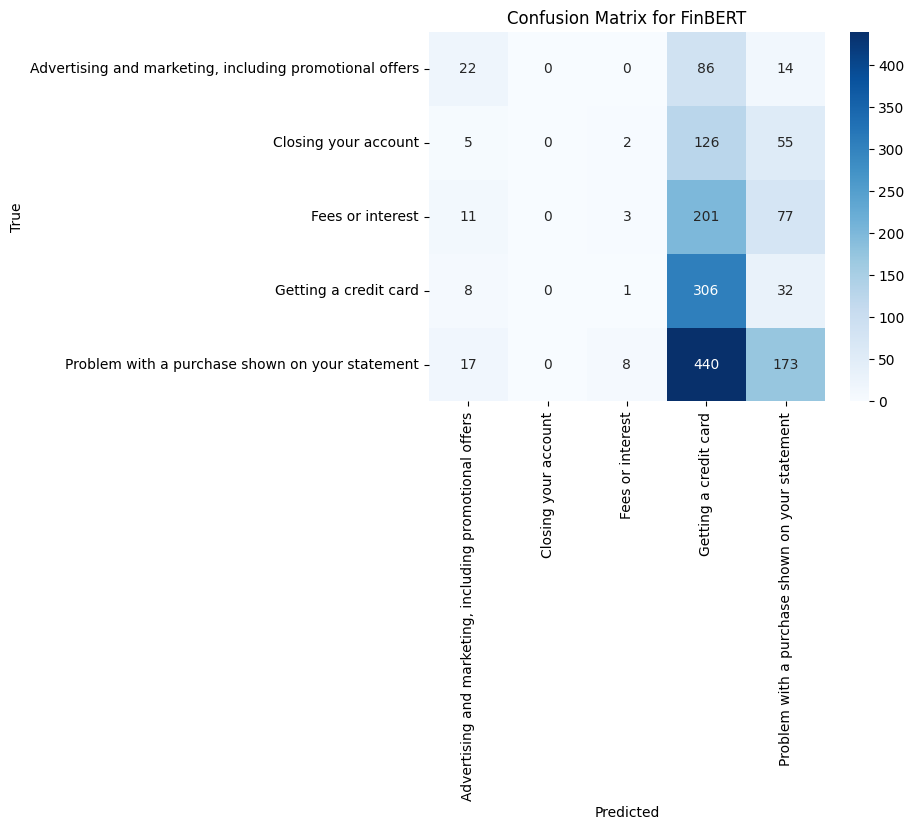

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = label_names
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for FinBERT')
plt.show()

## Fintuning the model

In [38]:
# 3. Define a Configurable Metrics Function
# ------------------------------------------
# This function generator creates a compute_metrics function based on the provided configuration.
# You can set which metrics to compute by modifying the metric_config dictionary.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metrics = {}
    # Always compute accuracy
    metrics["accuracy"] = accuracy_score(labels, predictions)

    return metrics

This code defines the hyperparameters and settings for the training process, such as learning rate, batch size, and number of epochs.


In [40]:
# 5. Set Up Training Arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="./results",             # output directory
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,                 # adjust epochs based on your task
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    fp16=True,
#    tpu_num_cores=8,  # Use all 8 TPU cores
)

This section initializes the Trainer with the model, training arguments, and datasets, and then starts the fine-tuning process.

In [41]:
model.train()

# 6. Initialize the Trainer and Fine-Tune the Model
# --------------------------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,  # pass our configurable metrics function
    processing_class=tokenizer,
)

# Fine-tune the model
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.669100,0.582606,0.812224
2,0.438700,0.529348,0.829868
3,0.316000,0.568820,0.834909
4,0.270100,0.611073,0.831758
5,0.133000,0.642305,0.834279


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=1985, training_loss=0.3754567669981373, metrics={'train_runtime': 549.9114, 'train_samples_per_second': 57.682, 'train_steps_per_second': 3.61, 'total_flos': 2086526869739520.0, 'train_loss': 0.3754567669981373, 'epoch': 5.0})

## Predicting on the evalution dataset using the new model

In [45]:
# Get raw predictions on the test set
predictions_output = trainer.predict(eval_dataset)

# Extract logits and true labels
logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted class indices
predicted_labels = np.argmax(logits, axis=-1)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


This section calculates and displays the confusion matrix to evaluate the performance of the trained model.


In [46]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the raw confusion matrix
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[ 70   3  23  15  11]
 [  2 115  26  27  18]
 [ 26   6 227   8  25]
 [  3   4   3 320  17]
 [  5  12  15  21 585]]


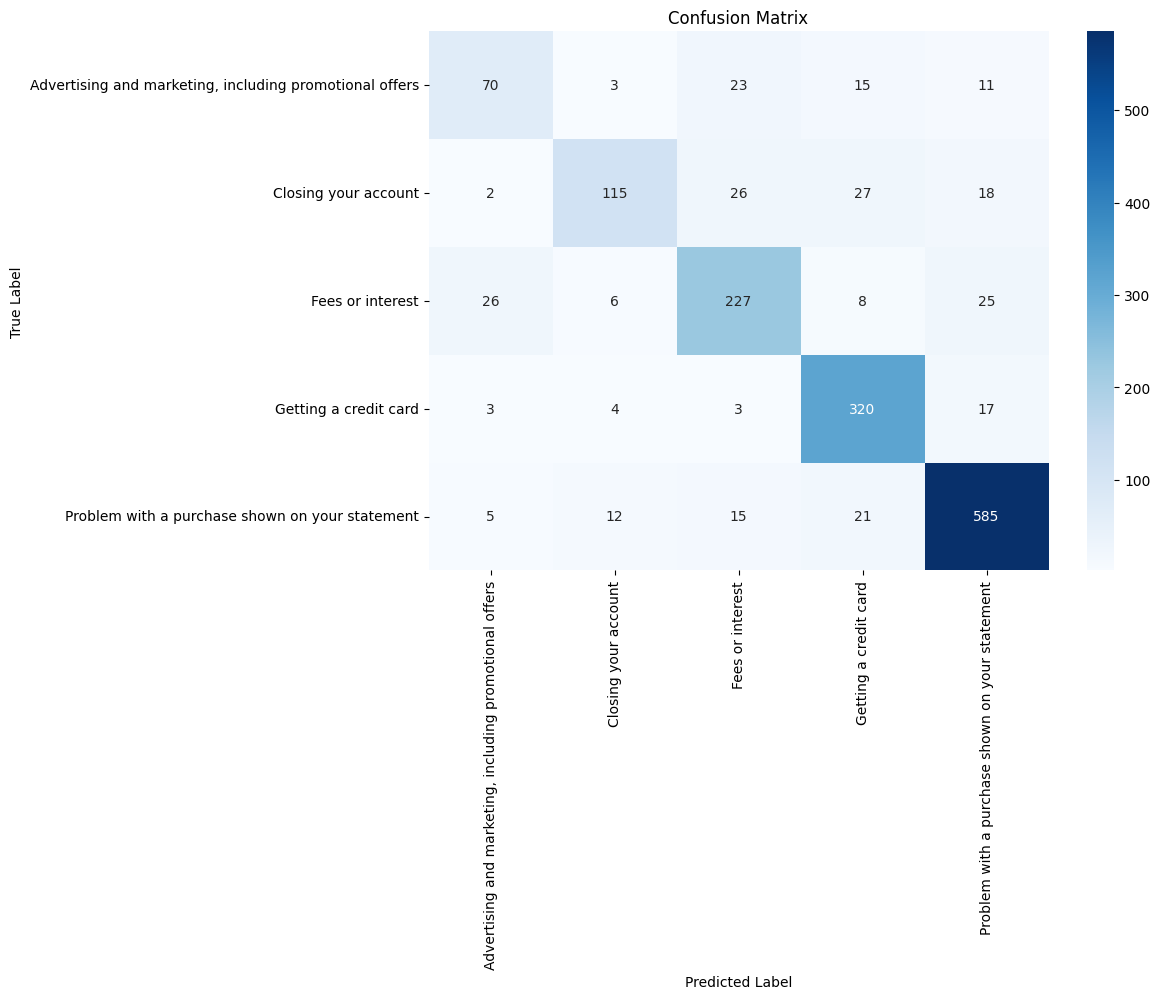

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

label_names = list(label_mapping.values())

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Saving the trained model and tokenizer for later use.


In [43]:
# 7. Save the Fine-Tuned Model and Tokenizer
# -------------------------------------------
# After training, save the model and tokenizer so that you can load them later for inference.
model_save_path = "./modelnew"
trainer.save_model(model_save_path)  # Saves the model
tokenizer.save_pretrained(model_save_path)  # Saves the tokenizer

print(f"Model and tokenizer saved to {model_save_path}")


Model and tokenizer saved to ./modelnew


## Using the model in production


In [44]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# 8. Load the Saved Model and Tokenizer
# -------------------------------------
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(model_save_path)

# Create a text classification pipeline using the loaded model and tokenizer
classifier = pipeline("text-classification", model=loaded_model, tokenizer=loaded_tokenizer)

Device set to use cuda:0


This section demonstrates how to use the trained model to classify new consumer complaints and print the predictions.


In [51]:
# 9. Classify New Consumer Complaints
# ------------------------------------
# List of new complaint texts to classify.
new_complaints = [
    "I am extremely disappointed with the bank's customer service and hidden fees."
]

# Get predictions for the new complaints.
predictions = classifier(new_complaints)

# Print out the predictions.
for complaint, pred in zip(new_complaints, predictions):
    print(f"Complaint: {complaint}")
    print(f"Prediction: {pred}\n")

Complaint: I am extremely disappointed with the bank's customer service and hidden fees.
Prediction: {'label': 'LABEL_2', 'score': 0.9689628481864929}



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [52]:
label_mapping

{0: 'Advertising and marketing, including promotional offers',
 1: 'Closing your account',
 2: 'Fees or interest',
 3: 'Getting a credit card',
 4: 'Problem with a purchase shown on your statement'}